In [1]:
import sys
import os
import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# import mpl_toolkits.axisartist
# from mpl_toolkits.axes_grid1 import host_subplot

import scipy.interpolate
import pandas as pd

# import statsmodels.formula.api as smformula
# import dateutil
# from collections import OrderedDict

from IPython.display import display, HTML
%matplotlib notebook
plt.style.use('seaborn-paper')

# special-ish extensions
# %load_ext Cython

In [2]:
# constants
FN = '2017_MAT_rep{}data.xlsx'
treatments = ['Low', 'High', 'Super High']

In [3]:
def load_rep_catch_data(rep, filename_pattern):
    df = pd.read_excel(filename_pattern.format(rep))

    if rep in [1,2]:
        foo = df[['Date Collected','Treatment','Row','Trap #','Pink','Blue','Yellow','Arc Yellow']].copy(deep=True)
        foo = foo[pd.notnull(foo['Date Collected'])]
        foo.loc[:,['Pink','Blue','Yellow','Arc Yellow']] = foo.loc[:,['Pink','Blue','Yellow','Arc Yellow']].fillna(value=0)
        foo['Total'] = foo.loc[:,['Pink','Blue','Yellow','Arc Yellow']].sum(axis=1)
    else:
        foo = df[['Date','Treatment','Row','Trap #','# recaptured']].copy(deep=True)
        foo.rename(columns={'Date':'Date Collected', '# recaptured':'Total'}, inplace=True)
        foo = foo[pd.notnull(foo['Date Collected'])]
        foo['Total'] = foo['Total'].fillna(value=0)

    return foo

# Raw trap catches

<IPython.core.display.Javascript object>


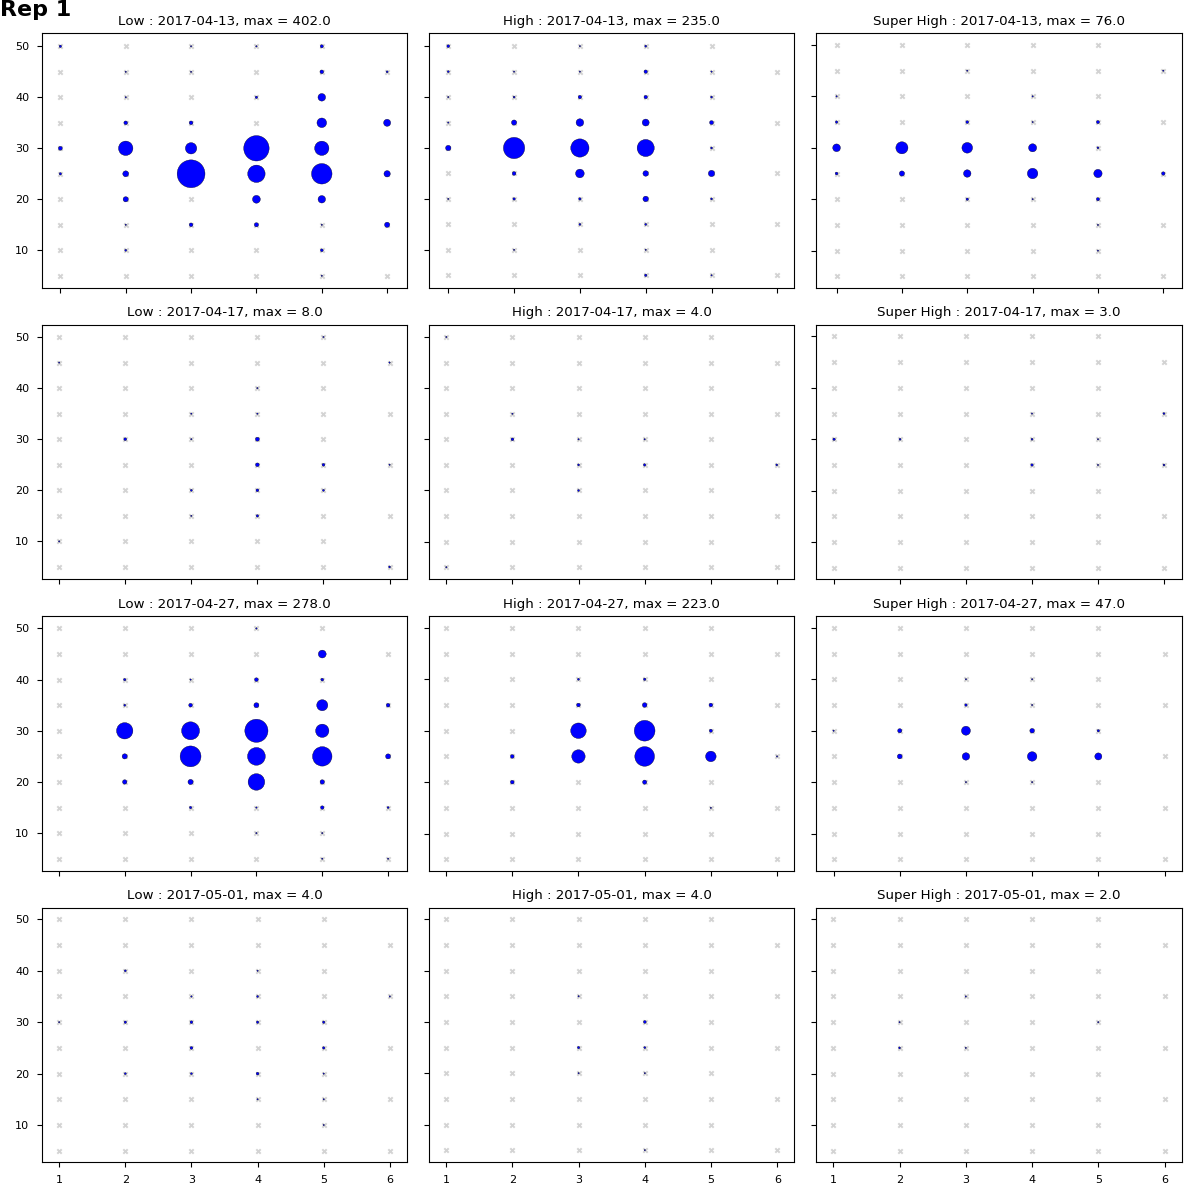

<IPython.core.display.Javascript object>


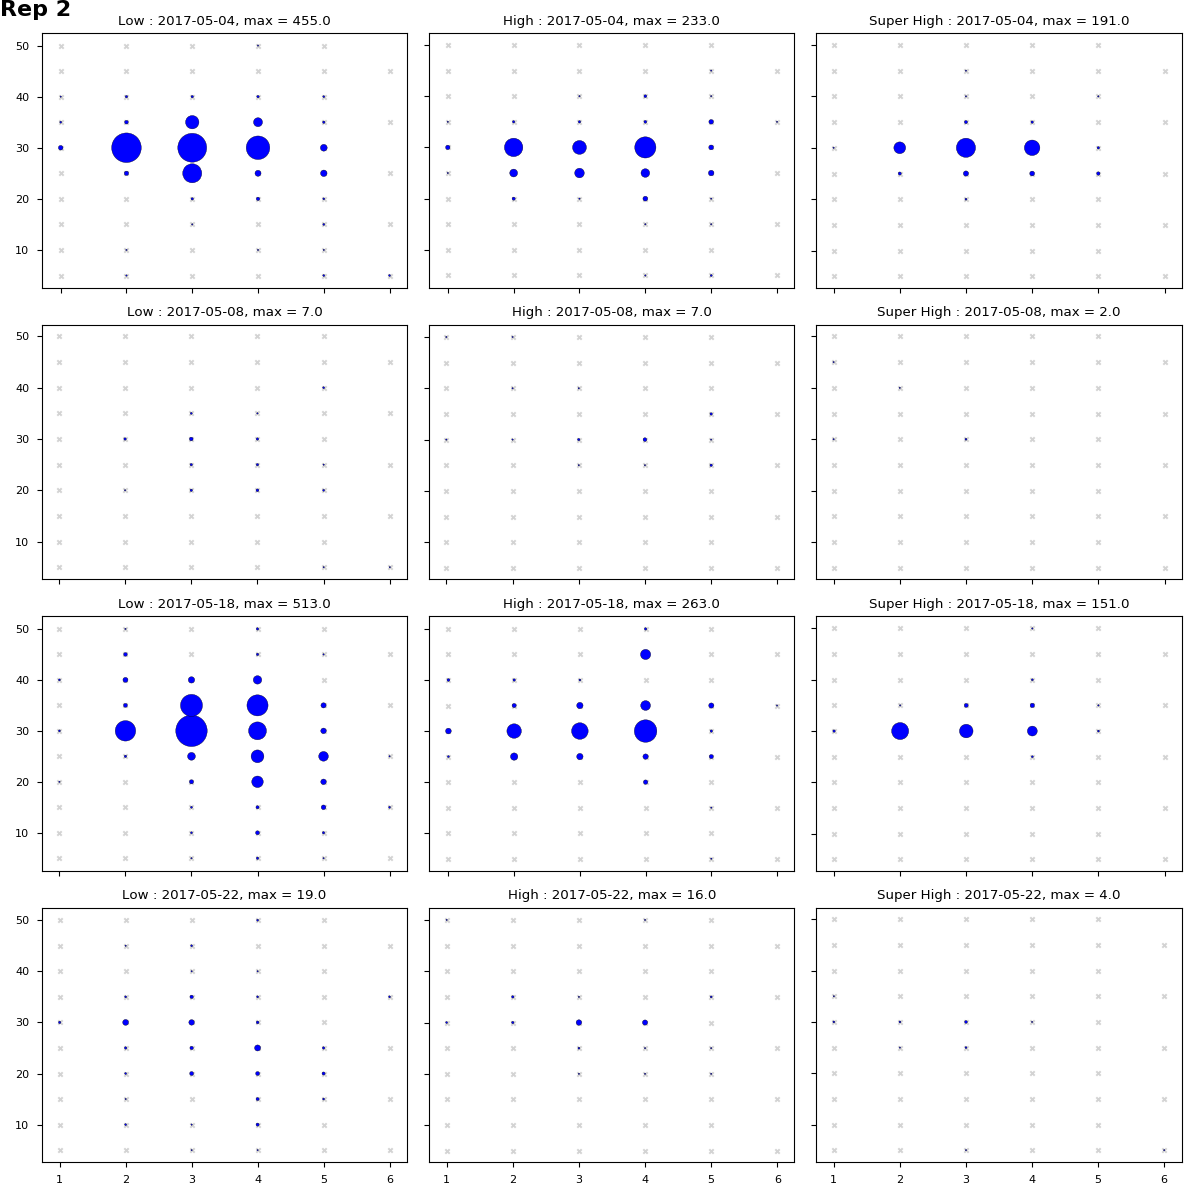

<IPython.core.display.Javascript object>


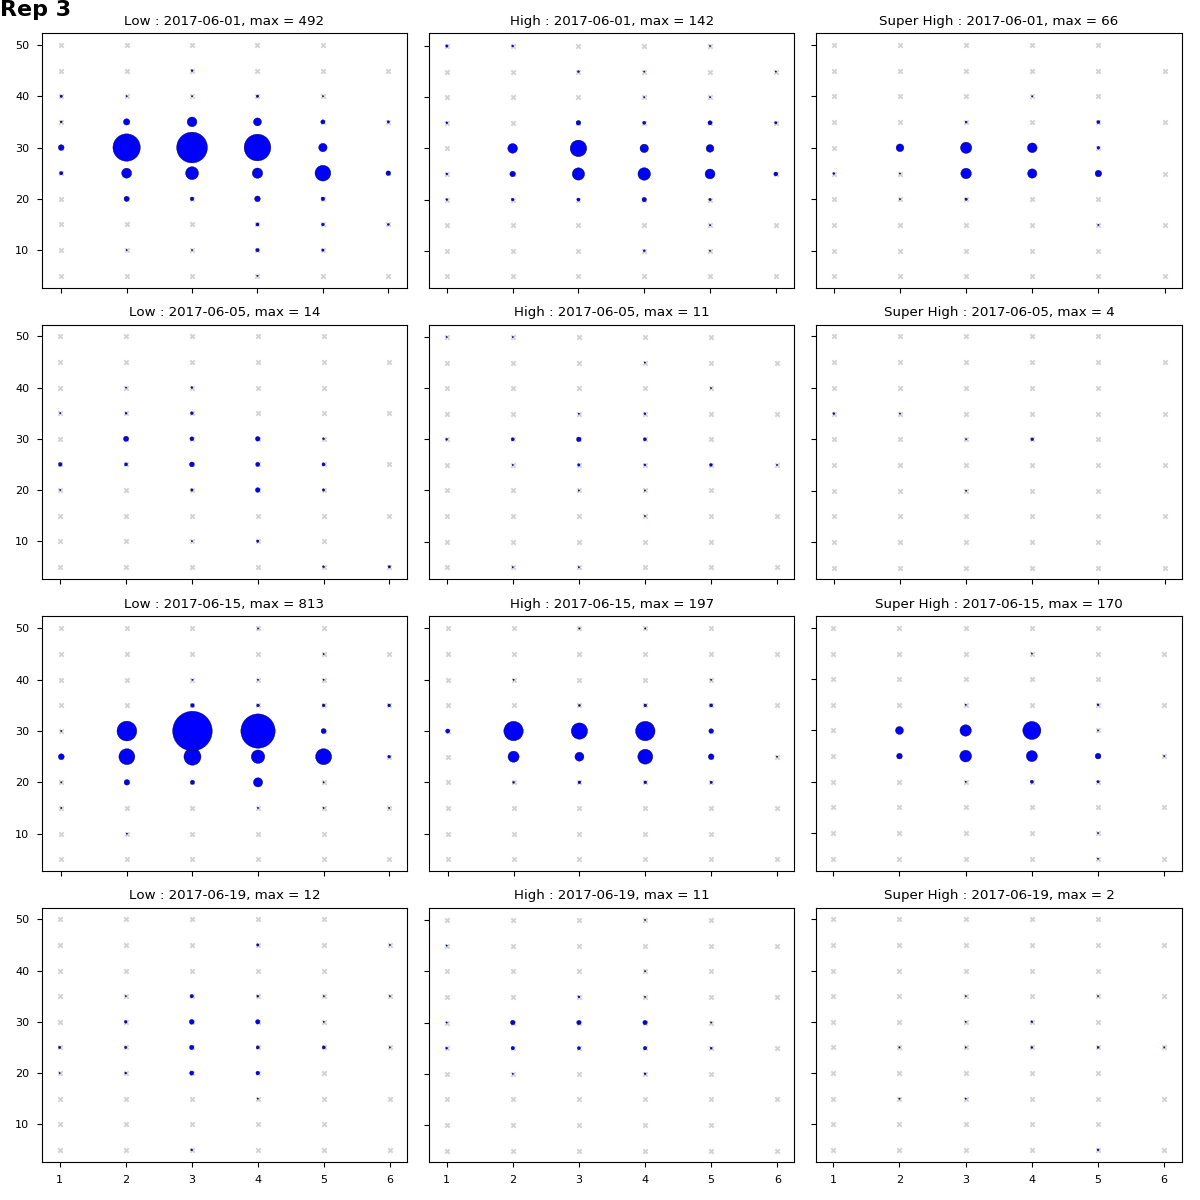

In [4]:
for rep in [1,2,3]:
    df = load_rep_catch_data(rep, FN)
    
    fig = plt.figure(figsize=(12,12))
    gs = mpl.gridspec.GridSpec(4,len(treatments))

    for ti, treatment in enumerate(treatments):
        foo = df[df['Treatment'] == treatment].copy(deep=True)
        dates = pd.to_datetime(foo['Date Collected'].unique())
        assert len(dates) == 4

        for di, date in enumerate(dates):
            tmp = foo[foo['Date Collected'] == date]

            ax = fig.add_subplot(gs[di,ti])
            ax.scatter(x=tmp['Trap #'], y=tmp['Row'], s=10, marker='x', color='lightgray')
            ax.scatter(x=tmp['Trap #'], y=tmp['Row'], s=tmp['Total'], color='b', edgecolor='k')
            ax.set_title("{} : {}, max = {}".format(treatment, date.strftime('%Y-%m-%d'), tmp['Total'].max()))
            if ti>0:
                ax.set_yticklabels([])
            if di<len(dates)-1:
                ax.set_xticklabels([])

    ax.text(0,1, 'Rep {}'.format(rep), transform=fig.transFigure, fontsize=16, fontweight='bold', va='top', ha='left')

    # gs.tight_layout(fig, rect=[])
    fig.tight_layout()

    fig.savefig('rep{}.png'.format(rep))

# Inferring block/hat kills

In [5]:
df = load_rep_catch_data(1,FN)

df = df[df['Treatment'] == 'Super High']
df = df[df['Date Collected'] == df['Date Collected'].unique()[0]]
df['x'] = df['Trap #']
df['y'] = df['Row']
df

,Date Collected,Treatment,Row,Trap #,Pink,Blue,Yellow,Arc Yellow,Total,x,y
112,2017-04-13,Super High,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0
113,2017-04-13,Super High,5.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0
114,2017-04-13,Super High,5.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0
115,2017-04-13,Super High,5.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0
116,2017-04-13,Super High,5.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
117,2017-04-13,Super High,5.0,6.0,0.0,0.0,0.0,0.0,0.0,6.0,5.0
118,2017-04-13,Super High,10.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0
119,2017-04-13,Super High,10.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,10.0
120,2017-04-13,Super High,10.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,10.0
121,2017-04-13,Super High,10.0,4.0,0.0,0.0,0.0,0.0,0.0,4.0,10.0


In [6]:
foo = df[['Total','x','y']].reset_index(drop=True)

traps_xy = foo.copy(deep=True)
traps_xy.index = traps_xy.apply(lambda x: '{},{}'.format(x['y'],x['x']), axis=1)

foo = foo.pivot(index='y', columns='x')
foo.columns = foo.columns.droplevel(0)
foo


x,1.0,2.0,3.0,4.0,5.0,6.0
y,,,,,,
5.0,0.0,0.0,0.0,0.0,0.0,0.0
10.0,0.0,0.0,0.0,0.0,1.0,NaN
15.0,0.0,0.0,0.0,0.0,1.0,0.0
20.0,0.0,0.0,3.0,1.0,5.0,NaN
25.0,4.0,14.0,29.0,57.0,36.0,6.0
30.0,31.0,76.0,59.0,34.0,2.0,NaN
35.0,3.0,0.0,4.0,1.0,5.0,0.0
40.0,1.0,0.0,0.0,1.0,0.0,NaN
45.0,0.0,0.0,1.0,0.0,0.0,1.0


In [7]:
high_hats = np.arange(0.5, 6.5+0.1, 0.5)
super_high_hats = np.arange(0.5, 6.5+0.1, 0.25)

for x in super_high_hats:
    if not x in foo.columns:
        foo.loc[:,x] = np.nan
foo.sort_index(axis=0, inplace=True)
foo.sort_index(axis=1, inplace=True)
foo

x,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,...,4.25,4.5,4.75,5.0,5.25,5.5,5.75,6.0,6.25,6.5
y,,,,,,,,,,,,,,,,,,,,,
5.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN
10.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
15.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN
20.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
25.0,NaN,NaN,4.0,NaN,NaN,NaN,14.0,NaN,NaN,NaN,...,NaN,NaN,NaN,36.0,NaN,NaN,NaN,6.0,NaN,NaN
30.0,NaN,NaN,31.0,NaN,NaN,NaN,76.0,NaN,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
35.0,NaN,NaN,3.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,0.0,NaN,NaN
40.0,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
45.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,NaN,NaN


In [8]:
foo = foo.interpolate(axis=1).where(foo.bfill(axis=1).notnull()) # where part fixes extrapolation to the right
foo

x,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,...,4.25,4.5,4.75,5.0,5.25,5.5,5.75,6.0,6.25,6.5
y,,,,,,,,,,,,,,,,,,,,,
5.0,NaN,NaN,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.0,NaN,NaN
10.0,NaN,NaN,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.25,0.5,0.75,1.0,NaN,NaN,NaN,NaN,NaN,NaN
15.0,NaN,NaN,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,...,0.25,0.5,0.75,1.0,0.75,0.5,0.25,0.0,NaN,NaN
20.0,NaN,NaN,0.0,0.00,0.0,0.00,0.0,0.75,1.5,2.25,...,2.00,3.0,4.00,5.0,NaN,NaN,NaN,NaN,NaN,NaN
25.0,NaN,NaN,4.0,6.50,9.0,11.50,14.0,17.75,21.5,25.25,...,51.75,46.5,41.25,36.0,28.50,21.0,13.50,6.0,NaN,NaN
30.0,NaN,NaN,31.0,42.25,53.5,64.75,76.0,71.75,67.5,63.25,...,26.00,18.0,10.00,2.0,NaN,NaN,NaN,NaN,NaN,NaN
35.0,NaN,NaN,3.0,2.25,1.5,0.75,0.0,1.00,2.0,3.00,...,2.00,3.0,4.00,5.0,3.75,2.5,1.25,0.0,NaN,NaN
40.0,NaN,NaN,1.0,0.75,0.5,0.25,0.0,0.00,0.0,0.00,...,0.75,0.5,0.25,0.0,NaN,NaN,NaN,NaN,NaN,NaN
45.0,NaN,NaN,0.0,0.00,0.0,0.00,0.0,0.25,0.5,0.75,...,0.00,0.0,0.00,0.0,0.25,0.5,0.75,1.0,NaN,NaN


In [9]:
pts = foo.unstack().reset_index()
pts.rename(columns={0:'Total'}, inplace=True)
pts.index = pts.apply(lambda x: '{},{}'.format(x['y'],x['x']), axis=1)
pts

,x,y,Total
"5.0,0.5",0.50,5.0,NaN
"10.0,0.5",0.50,10.0,NaN
"15.0,0.5",0.50,15.0,NaN
"20.0,0.5",0.50,20.0,NaN
"25.0,0.5",0.50,25.0,NaN
"30.0,0.5",0.50,30.0,NaN
"35.0,0.5",0.50,35.0,NaN
"40.0,0.5",0.50,40.0,NaN
"45.0,0.5",0.50,45.0,NaN
"50.0,0.5",0.50,50.0,NaN


<IPython.core.display.Javascript object>


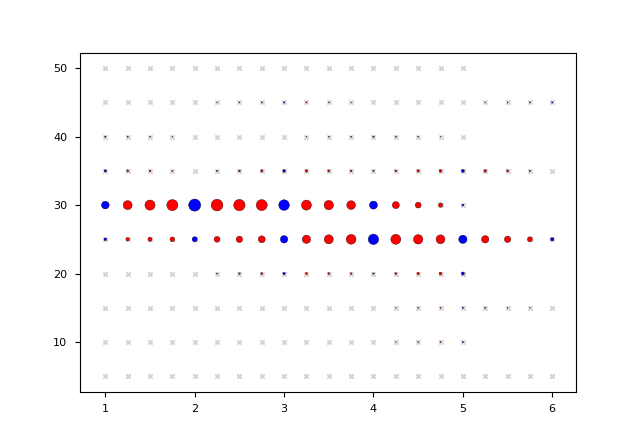

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

tmp = pts.dropna()
ax.scatter(x=tmp['x'], y=tmp['y'], s=10, marker='x', color='lightgray')

tmp = pts.loc[traps_xy.index]
ax.scatter(x=tmp['x'], y=tmp['y'], s=tmp['Total'], color='b', edgecolor='k')

tmp = pts.loc[pts.index.difference(traps_xy.index)]
ax.scatter(x=tmp['x'], y=tmp['y'], s=tmp['Total'], color='r', edgecolor='k')

<IPython.core.display.Javascript object>


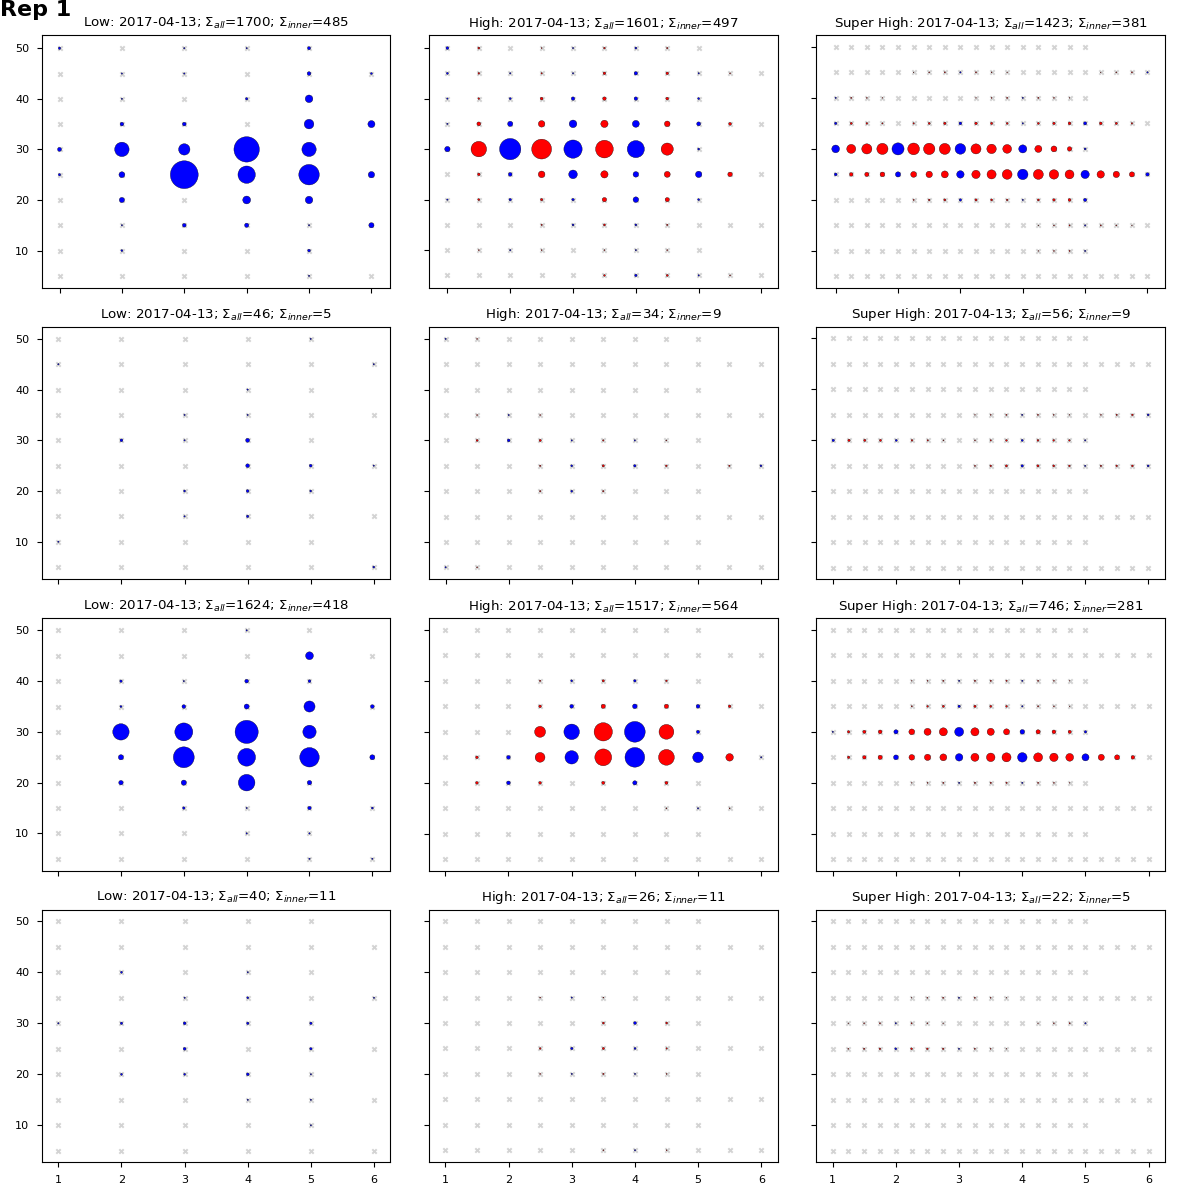

Low: 2017-04-13; $\Sigma_{all}$=1700; $\Sigma_{inner}$=485
Low: 2017-04-13; $\Sigma_{all}$=46; $\Sigma_{inner}$=5
Low: 2017-04-13; $\Sigma_{all}$=1624; $\Sigma_{inner}$=418
Low: 2017-04-13; $\Sigma_{all}$=40; $\Sigma_{inner}$=11
High: 2017-04-13; $\Sigma_{all}$=1601; $\Sigma_{inner}$=497
High: 2017-04-13; $\Sigma_{all}$=34; $\Sigma_{inner}$=9
High: 2017-04-13; $\Sigma_{all}$=1517; $\Sigma_{inner}$=564
High: 2017-04-13; $\Sigma_{all}$=26; $\Sigma_{inner}$=11
Super High: 2017-04-13; $\Sigma_{all}$=1423; $\Sigma_{inner}$=381
Super High: 2017-04-13; $\Sigma_{all}$=56; $\Sigma_{inner}$=9
Super High: 2017-04-13; $\Sigma_{all}$=746; $\Sigma_{inner}$=281
Super High: 2017-04-13; $\Sigma_{all}$=22; $\Sigma_{inner}$=5


<IPython.core.display.Javascript object>


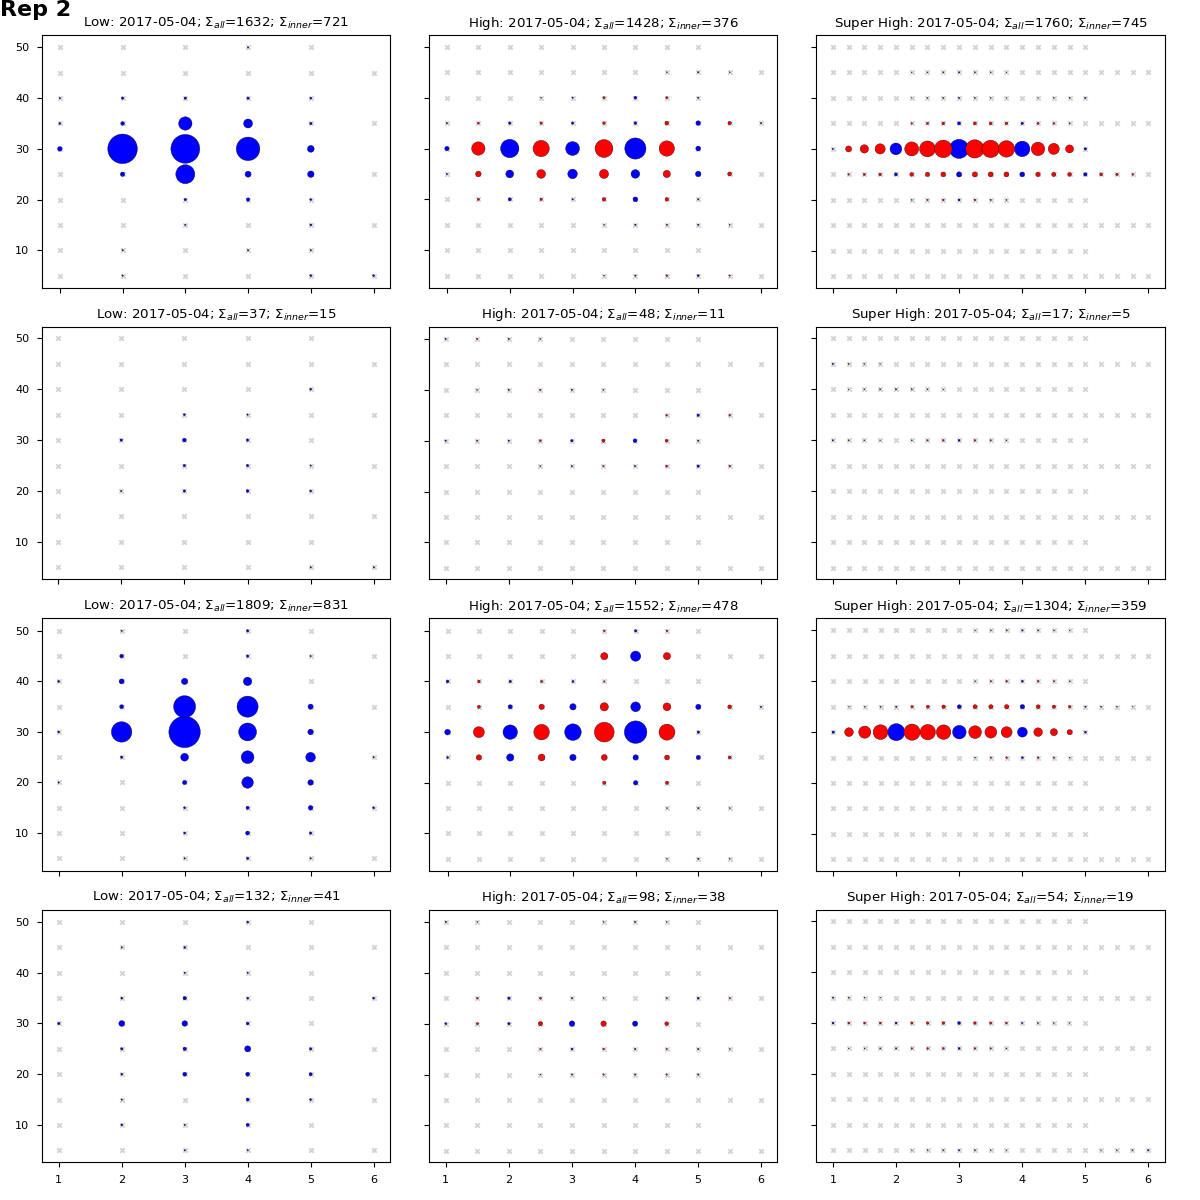

Low: 2017-05-04; $\Sigma_{all}$=1632; $\Sigma_{inner}$=721
Low: 2017-05-04; $\Sigma_{all}$=37; $\Sigma_{inner}$=15
Low: 2017-05-04; $\Sigma_{all}$=1809; $\Sigma_{inner}$=831
Low: 2017-05-04; $\Sigma_{all}$=132; $\Sigma_{inner}$=41
High: 2017-05-04; $\Sigma_{all}$=1428; $\Sigma_{inner}$=376
High: 2017-05-04; $\Sigma_{all}$=48; $\Sigma_{inner}$=11
High: 2017-05-04; $\Sigma_{all}$=1552; $\Sigma_{inner}$=478
High: 2017-05-04; $\Sigma_{all}$=98; $\Sigma_{inner}$=38
Super High: 2017-05-04; $\Sigma_{all}$=1760; $\Sigma_{inner}$=745
Super High: 2017-05-04; $\Sigma_{all}$=17; $\Sigma_{inner}$=5
Super High: 2017-05-04; $\Sigma_{all}$=1304; $\Sigma_{inner}$=359
Super High: 2017-05-04; $\Sigma_{all}$=54; $\Sigma_{inner}$=19


<IPython.core.display.Javascript object>


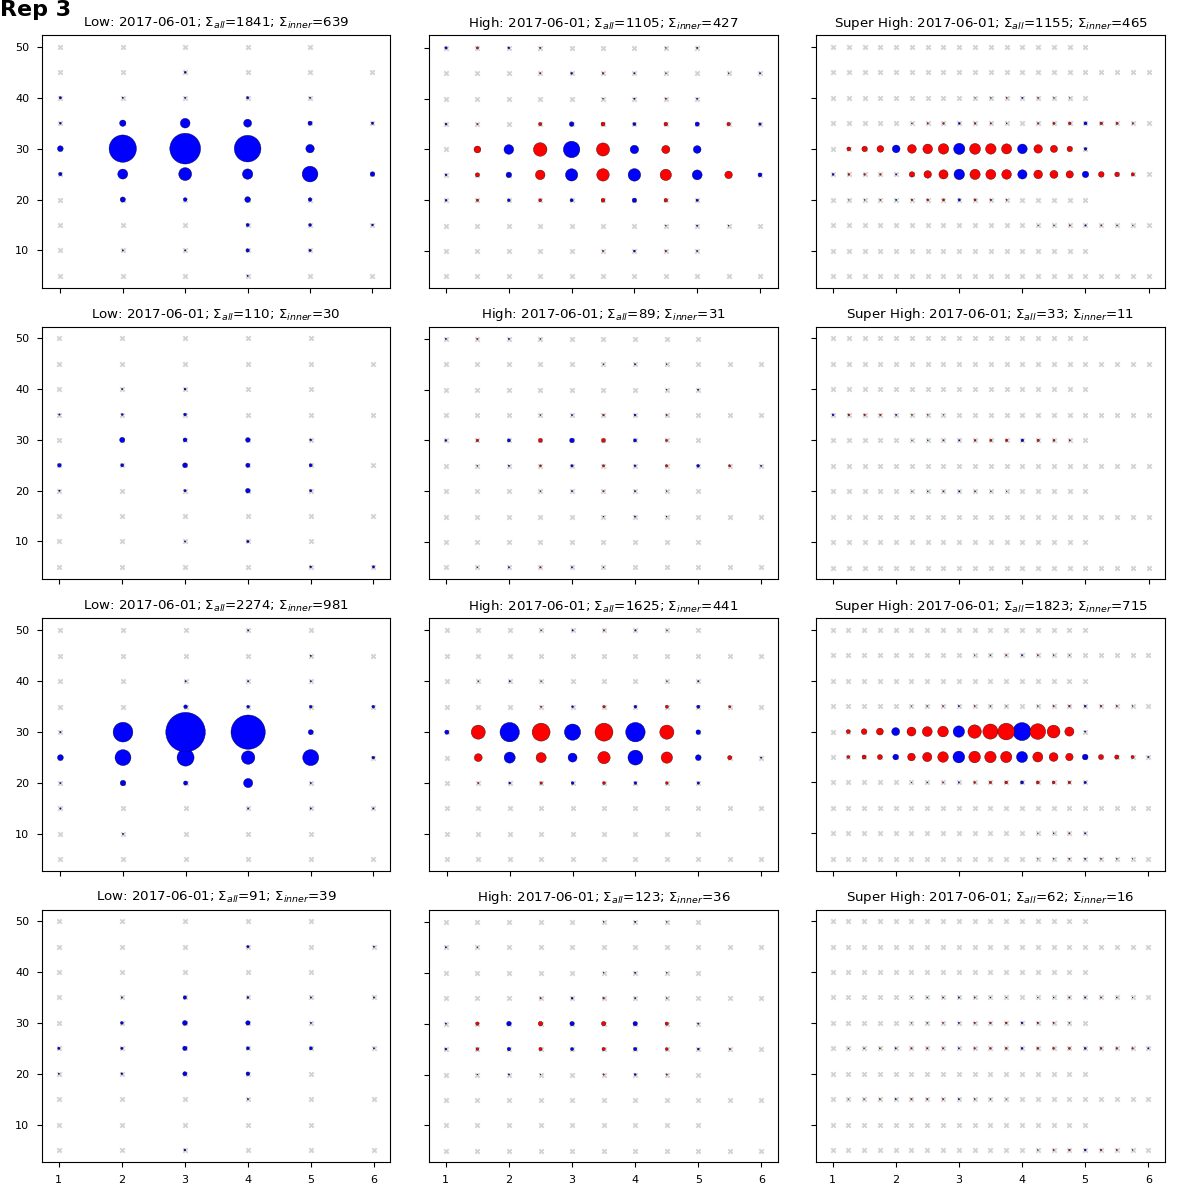

Low: 2017-06-01; $\Sigma_{all}$=1841; $\Sigma_{inner}$=639
Low: 2017-06-01; $\Sigma_{all}$=110; $\Sigma_{inner}$=30
Low: 2017-06-01; $\Sigma_{all}$=2274; $\Sigma_{inner}$=981
Low: 2017-06-01; $\Sigma_{all}$=91; $\Sigma_{inner}$=39
High: 2017-06-01; $\Sigma_{all}$=1105; $\Sigma_{inner}$=427
High: 2017-06-01; $\Sigma_{all}$=89; $\Sigma_{inner}$=31
High: 2017-06-01; $\Sigma_{all}$=1625; $\Sigma_{inner}$=441
High: 2017-06-01; $\Sigma_{all}$=123; $\Sigma_{inner}$=36
Super High: 2017-06-01; $\Sigma_{all}$=1155; $\Sigma_{inner}$=465
Super High: 2017-06-01; $\Sigma_{all}$=33; $\Sigma_{inner}$=11
Super High: 2017-06-01; $\Sigma_{all}$=1823; $\Sigma_{inner}$=715
Super High: 2017-06-01; $\Sigma_{all}$=62; $\Sigma_{inner}$=16


In [76]:
treatments = ['Low', 'High', 'Super High']
hatpos_high = np.arange(0.5, 6.5+0.1, 0.5)
hatpos_super_high = np.arange(0.5, 6.5+0.1, 0.25)

for rep in [1,2,3]:
    df = load_rep_catch_data(rep, FN)
    # and x,y cols for positions
    df['x'] = df['Trap #']
    df['y'] = df['Row']

    fig = plt.figure(figsize=(12,12))
    gs = mpl.gridspec.GridSpec(4,len(treatments))

    for ti, treatment in enumerate(treatments):
        tmp = df[df['Treatment'] == treatment]
        service_dates = pd.to_datetime(tmp['Date Collected'].unique())
        assert len(service_dates) == 4

        if treatment == 'High':
            hatpos = hatpos_high
        elif treatment == 'Super High':
            hatpos = hatpos_super_high
        else:
            assert treatment == 'Low'
            hatpos = []
            
        for di, service_date in enumerate(service_dates):
            foo = df[df['Treatment'] == treatment].copy(deep=True)
            foo = foo[foo['Date Collected'] == service_date]
            
            # reduce down to just the cols we need
            foo = foo[['Total','x','y']].reset_index(drop=True)

            # keep a copy of just actual traps (we will add hats in a bit)
            traps_xy = foo.copy(deep=True)
            traps_xy.index = traps_xy.apply(lambda x: '{},{}'.format(x['y'],x['x']), axis=1)

            # pivot to make x by y table of totals
            foo = foo.pivot(index='y', columns='x')
            foo.columns = foo.columns.droplevel(0)

            # add in the hats/blocks
            for x in hatpos:
                if not x in foo.columns:
                    foo.loc[:,x] = np.nan
            foo.sort_index(axis=0, inplace=True)
            foo.sort_index(axis=1, inplace=True)

            # interpolate
            foo = foo.interpolate(axis=1).where(foo.bfill(axis=1).notnull()) # where part fixes extrapolation to the right

            # flatten (to x,y,total list)
            pts = foo.unstack().reset_index()
            pts.rename(columns={0:'Total'}, inplace=True)
            pts.index = pts.apply(lambda x: '{},{}'.format(x['y'],x['x']), axis=1)

            # sums
            tmp = pts#.copy(deep=True)
            sum_all = tmp['Total'].sum()
            tmp = tmp[(tmp['x']>=3) & (tmp['x']<4)] # restrict to middle columns (3 to 4, not including 4)
            #tmp = tmp[(tmp['y']>=25) & (tmp['y']<=30)] # restrict rows too?
            sum_inner_cols = tmp['Total'].sum()
            # print("Sum All        =", sum_all)
            # print("Sum Inner Cols =", sum_inner_cols)


            # plot
            ax = fig.add_subplot(gs[di,ti])

            tmp = pts.dropna()
            ax.scatter(x=tmp['x'], y=tmp['y'], s=10, marker='x', color='lightgray')

            tmp = pts.loc[traps_xy.index]
            ax.scatter(x=tmp['x'], y=tmp['y'], s=tmp['Total'], color='b', edgecolor='k')

            tmp = pts.loc[pts.index.difference(traps_xy.index)]
            ax.scatter(x=tmp['x'], y=tmp['y'], s=tmp['Total'], color='r', edgecolor='k')

            t = "{}: {}".format(treatment, pd.to_datetime(service_dates[service_number]).strftime('%Y-%m-%d'))
            t += r"; $\Sigma_{all}$="+str(int(sum_all))
            t += r"; $\Sigma_{inner}$="+str(int(sum_inner_cols))
            ax.set_title(t)
            print(t)

            if ti>0:
                ax.set_yticklabels([])
            if di<len(dates)-1:
                ax.set_xticklabels([])
            
#             break
#         break
#     break

    ax.text(0,1, 'Rep {}'.format(rep), transform=fig.transFigure, fontsize=16, fontweight='bold', va='top', ha='left')

    # gs.tight_layout(fig, rect=[])
    fig.tight_layout()

    fig.savefig('rep{}_inferred.png'.format(rep))